## UKF HELPER FUNCTIONS

In [1]:
import pykalman

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def coordinatedTurnMotion(x, T):
    """
    COORDINATEDTURNMOTION calculates the predicted state using a coordinated
    turn motion model, and also calculated the motion model Jacobian

    Input:
       x           [5 x 1] state vector
       T           [1 x 1] Sampling time

    Output:
       fx          [5 x 1] motion model evaluated at state x
       Fx          [5 x 5] motion model Jacobian evaluated at state x

     NOTE: the motion model assumes that the state vector x consist of the
     following states:
       px          X-position
       py          Y-position
       v           velocity
       phi         heading
       omega       turn-rate
    """
    fx = np.array([
            x[0] + (T *x[2]* np.cos(x[3])),
            x[1] + (T *x[2]* np.sin(x[3])),
            x[2]                      ,
            x[3] + T *x[4]            ,
            x[4]                      
        ]).reshape((5,1))

    Fx = np.array([
            [ 1, 0, T * np.cos(x[3]), -T * x[2] * np.sin(x[3]), 0],        
            [ 0, 1, T * np.sin(x[3]),  T * x[2] * np.cos(x[3]), 0],
            [ 0, 0, 1               ,  0                      , 0],
            [ 0, 0, 0               ,  1                      , T],
            [ 0, 0, 0               ,  0                      , 1]
        ])

    return fx, Fx

In [17]:
def sigmaPoints(x, P, kf_type):
    """
    SIGMAPOINTS computes sigma points, either using unscented transform or using cubature.

    Input:
       x           [n x 1] Prior mean
       P           [n x n] Prior covariance

    Output:
       SP          [n x 2n+1] UKF, [n x 2n] CKF. Matrix with sigma points
       W           [1 x 2n+1] UKF, [1 x 2n] UKF. Vector with sigma point weights 
    """
    
    n = x.shape[0] # state vector size
    
    if(kf_type =='UKF'):
        # initialise the variables
        SP = np.zeros((n, 2*n + 1))
        W  = np.zeros((2*n + 1))

        # calculating the weights
        W_0   = 1 - (n/3)
        W[0]  = W_0
        W[1:] = (1 - W_0) / (2*n)

        # sigma points
        P_root = np.linalg.cholesky(P) # lower triangular matrix by default
        factor = np.sqrt(n / (1- W_0))

        SP[:,0] = x.flatten();            
        for i in range(n):
            SP[:,i+1]   = x.flatten()  + (factor * P_root[:,i]).flatten();
            SP[:,i+1+n] = x.flatten()  - (factor * P_root[:,i]).flatten();
        
    return SP, W

In [5]:
def nonLinKFprediction(x, P, f, Q, kf_type):
    """
    NONLINKFPREDICTION calculates mean and covariance of predicted state
       density using a non-linear Gaussian model.

    Input:
       x           [n x 1] Prior mean
       P           [n x n] Prior covariance
       f           Motion model function handle
                   [fx,Fx]=f(x) 
                   Takes as input x (state), 
                   Returns fx and Fx, motion model and Jacobian evaluated at x
                   All other model parameters, such as sample time T,
                   must be included in the function
       Q           [n x n] Process noise covariance
       type        String that specifies the type of non-linear filter

    Output:
       x           [n x 1] predicted state mean
       P           [n x n] predicted state covariance
    """

    if(kf_type =='UKF'):
        
        # generatesigma points
        SP,W = sigmaPoints(x, P, kf_type)

        # find the approximate mean          
        x_new = np.zeros(x.shape);
        for index in range (1, SP.shape[1]):
            predicted_sigma_pts, jac_fx = f(SP[:, index]); 
            x_new = x_new + (predicted_sigma_pts * W[index])

        # find the approximate covariance
        P_new = Q;
        for index in range (1, SP.shape[1]):
            predicted_sigma_pts, jac_fx = f(SP[:, index])  
            sigma_pt_variance = (predicted_sigma_pts - x_new) @ (predicted_sigma_pts - x_new).T
            P_new = P_new + (sigma_pt_variance * W[index])

        x = x_new;
        P = P_new;
    
    return x, P

In [6]:
def linearUpdate(x, P, y, H, R):
    """
    LINEARUPDATE calculates mean and covariance of updated state
       density using a linear Gaussian model.

    Input:
       x           [n x 1] Prior mean
       P           [n x n] Prior covariance
       y           [m x 1] Measurement
       H           [m x n] Measurement model matrix
       R           [m x m] Measurement noise covariance

    Output:
       x           [n x 1] updated state mean
       P           [n x n] updated state covariance
    """
    vk = y - H @ x
    S  = (H @ P @ H.T) + R
    Kalman_gain = P @ H.T @ np.linalg.inv(S)

    x = x + Kalman_gain @ vk
    P = P - (Kalman_gain @ S @ Kalman_gain.T)
    
    return x, P

In [19]:
def nonLinearKalmanFilter(Y, x_0, P_0, f, Q, H, R, kf_type = 'UKF'):
    """
        NONLINEARKALMANFILTER Filters measurement sequence Y using a 
         non-linear Kalman filter. 

        Input:
           Y           [m x N] Measurement sequence for times 1,...,N
           x_0         [n x 1] Prior mean for time 0
           P_0         [n x n] Prior covariance
           f                   Motion model function handle
                               [fx,Fx]=f(x) 
                               Takes as input x (state) 
                               Returns fx and Fx, motion model and Jacobian evaluated at x
           Q           [n x n] Process noise covariance
           H           [m x n] Returns hx and Hx, measurement model and Jacobian evaluated at x
           R           [m x m] Measurement noise covariance

        Output:
           xf          [n x N]     Filtered estimates for times 1,...,N
           Pf          [n x n x N] Filter error convariance
           xp          [n x N]     Predicted estimates for times 1,...,N
           Pp          [n x n x N] Filter error convariance
    """

    # Parameters
    N = Y.shape[1]    # timesteps
    n = x_0.shape[0]  # state size
    m = Y.shape[0]    # measuremnent size

    # Data allocation    
    xf = np.zeros((n,N))
    Pf = np.zeros((n,n,N))
    
    # initial value for estimates
    xk  = x_0
    Pk = P_0
    
    for i in range(0,N):
        # prediction step: compute p(x_k | y_1:k-1) from p(x_k-1 | y_1:k-1)
        xp, Pp = nonLinKFprediction(xk, Pk, f, Q, kf_type)
        
        print(xp.shape, Pp.shape)
        # update step: compute p(x_k | y_1:k) from p(x_k | y_1:k-1)
        xk, Pk = linearUpdate(xp, Pp, Y[:,i], H, R)
        
        xf[:, i]  = xk
        Pf[:,:,i] = Pk
    
    return xf, Pf

/home/wabco/miniconda3/envs/lyft/lib/python3.6/site-packages/pykalman/unscented.py:867: RuntimeWarning: covariance is not positive-semidefinite.
  observation_covariance.newbyteorder('=')


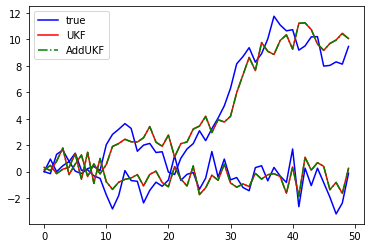

In [8]:
import pylab as pl
from pykalman import AdditiveUnscentedKalmanFilter, UnscentedKalmanFilter

# initialize parameters
def transition_function(state, noise):
    a = state[0] * np.sin(state[1]) + noise[0]
    b = state[1] + noise[1]
    return np.array([a, b])

def observation_function(state, noise):
    C = np.array([[-1, 0.5], [0.2, 0.1]])
    return np.dot(C, state) + noise

def additive_transition_function(state):
    return transition_function(state, np.array([0, 0]))

def additive_observation_function(state):
    return observation_function(state, np.array([0, 0]))

transition_covariance = np.eye(2)
random_state = np.random.RandomState(0)
observation_covariance = np.eye(2) + random_state.randn(2, 2) * 0.1
initial_state_mean = [0, 0]
initial_state_covariance = [[1, 0.1], [ 0.1, 1]]

# sample from model
ukf = UnscentedKalmanFilter(
    transition_function, observation_function,
    transition_covariance, observation_covariance,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
akf = AdditiveUnscentedKalmanFilter(
    additive_transition_function, additive_observation_function,
    transition_covariance, observation_covariance,
    initial_state_mean, initial_state_covariance
)
states, observations = ukf.sample(50, initial_state_mean)

# estimate state with filtering
ukf_state_estimates = ukf.filter(observations)[0]
akf_state_estimates = akf.filter(observations)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_ukf = pl.plot(ukf_state_estimates, color='r', ls='-')
lines_akf = pl.plot(akf_state_estimates, color='g', ls='-.')
pl.legend((lines_true[0], lines_ukf[0], lines_akf[0]),
          ('true', 'UKF', 'AddUKF'),
          loc='upper left'
)
pl.show()

In [9]:
def temp_additive_transition_function(state):
    return transition_function(state, np.array([0, 0])), 0

C = np.array([[-1, 0.5], [0.2, 0.1]])

In [20]:
xt, pt = nonLinearKalmanFilter(observations.T, np.array(initial_state_mean).reshape(2,1), 
                      np.array(initial_state_covariance), 
                      temp_additive_transition_function, transition_covariance, 
                      C, observation_covariance, 'UKF')

(2, 2) (2, 2)


ValueError: could not broadcast input array from shape (2,2) into shape (2)